## Creation of the four PPS monomers

In [1]:
import mbuild as mb
import math
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt
import rowan

# Creates a mBuild compound of a single PPS monomer
pps = mb.load("c1ccc(S)cc1", smiles=True)

In [2]:
system = mb.compound.Compound()

In [3]:
#Creats a box with four monomers inside of it
for i in range(4):
    clone = mb.clone(pps)
    if i %2 == 0:
        clone.rotate(theta = i*(math.pi/2), around = [0, 0, 1])
    else:
        clone.rotate(theta = i*(math.pi/2), around = [0, 1, 0])
    clone.translate([(i + 1), 1, 1])
    system.add(clone)
system.box = mb.Box([6, 2, 2])

In [4]:
system.save("pps_box.gsd", overwrite=True)

/Users/noah/miniconda3/envs/grits/lib/python3.8/site-packages/gsd/hoomd.py:420: FutureWarning: Snapshot is deprecated, use Frame
  warnings.warn("Snapshot is deprecated, use Frame", FutureWarning)
/Users/noah/miniconda3/envs/grits/lib/python3.8/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'wb' mode is deprecated, use 'w'
  gsdfileobj = fl.open(name=str(name),


In [5]:
file = gsd.hoomd.open("pps_box.gsd", "r")

In [6]:
frame = file[0]

## Getting the positions of the particles in one monomer

In [7]:
pps.save("one_pps.gsd", overwrite=True)

In [8]:
def get_heavy_atoms(particles):
    """Returning arrays of only heavy atoms (non-Hydrogen) given a gsd.frame.particles object"""
    #partpos = particle position
    partpos = particles.position
    #partmass = particle mass
    partmass = particles.mass
    #elements
    partelem = particles.typeid
    heavy_atom_indicies = np.where(partelem != 1)[0]
    heavy_partpos = partpos[heavy_atom_indicies]
    heavy_partmass = partmass[heavy_atom_indicies]
    return heavy_partpos, heavy_partmass

In [9]:
with gsd.hoomd.open('one_pps.gsd') as f:
    frame = f[0]
    particles = frame.particles
    
heavy_partpos, heavy_partmass = get_heavy_atoms(particles)

### This function finds the two furthest united atoms from each other and computes the vector between the two atoms that will be used as the major axis

In [10]:
def get_major_axis(positions_arr):
    '''Finds the major axis for GB CG representation for use in axis-angle
    orientation representation.
    args:
        positions_arr: N_particlesx3 numpy array of particle positions to map to one aniso bead.
        elements_arr: List of length N_particles containing particle elements
    returns:
        major_axis: numpy array designating vector of major axis of Gay-Berne particle
        particle_indicies: tuple of two particle indices used to calculate major axis vector
    '''
    major_axis = None
    max_dist = 0
    AB_indicies = (None, None)
    for i, x0 in enumerate(positions_arr):
        for j, x1 in enumerate(positions_arr[i+1:]):
            vect = x1 - x0
            dist = np.linalg.norm(vect)
            if dist > max_dist:
                max_dist = dist
                major_axis = vect
                # adjust j for loop stride
                AB_indicies = (i, j+i+1)
    return major_axis, AB_indicies

### This function finds the center of mass of the given molecule

In [11]:
def get_com(particle_positions, particle_masses):
    '''Calculate center of mass coordinates given a set of particle positions and masses.
    Positions and Masses arrays must be of same dimension.
    args:
        particle_positions: N_particlesx3 numpy array of particle positions (x,y,z)
        particle_masses: N_particlesx0 numpy array of particle masses
        
    returns:
        center_of_mass: 3x0 numpy array of center of mass coordinates'''
    
    M = np.sum(particle_masses)
    weighted_positions = particle_positions * particle_masses[:,np.newaxis]
    center_of_mass = np.sum(weighted_positions/M, axis=0)
    return center_of_mass

### This function finds the furthest atom  from the Center of Mass that wasn't used to make the major axis, and creates a vector

In [12]:
#Convert the vector along the major axis at the center of mass and convert that to quaternions
def get_minor_axis(particle_positions, center_of_mass, AB_indicies):
    AB = particle_positions[AB_indicies[1]] - [AB_indicies[0]]
    CoM_vector = None
    maxdist = 0
    for i, vect0 in enumerate(particle_positions):
        if i in AB_indicies:
            continue
        quatvect = vect0 - center_of_mass
        dist = np.linalg.norm(quatvect)
        if dist > maxdist and not np.isclose(np.cross(AB, quatvect), np.zeros(3)).all():
            maxdist = dist
            CoM_vector = quatvect
    return CoM_vector

In [13]:
lpar, indicies = get_major_axis(heavy_partpos)
print(lpar)
pps_center = get_com(heavy_partpos, heavy_partmass)
print(pps_center)
CoM_vector = get_minor_axis(heavy_partpos, pps_center, indicies)
print(CoM_vector)

[ 4.510643   -0.03577537  0.8458322 ]
[ 0.6476411  -0.00234209  0.23149961]
[-1.6685975  -1.1976751  -0.27923286]


### The following two cells visualizes the plane created by lpar and the Center of mass to furthest non-lpar atom

In [14]:
def vect_3d_for_plotting(point, vector):
    """Makes xs, ys, zs, for plotting a vector from a given point in matplotlib"""
    vectnorm = np.linalg.norm(vector)
    xs = [point[0], point[0]+vector[0]]
    ys = [point[1], point[1]+vector[1]]
    zs = [point[2], point[2]+vector[2]]
    return xs, ys, zs

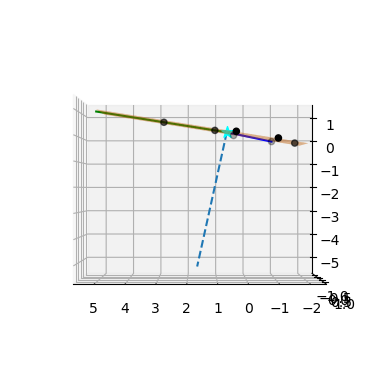

In [15]:
vect3d = vect_3d_for_plotting(pps_center, lpar) 
X = np.linspace(-2, 5, 50)
Y = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(X,Y)
n0 = np.cross(lpar, CoM_vector)
d = np.dot(pps_center, n0)
Z = (d - n0[0]*X - n0[1]*Y) / n0[2]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(heavy_partpos[:,0], heavy_partpos[:,1], heavy_partpos[:,2], color = 'black')
ax.scatter(*pps_center, marker = '*', s = 72, color = 'cyan')
ax.plot3D(*vect_3d_for_plotting(pps_center, lpar), color = 'green')
ax.plot3D(*vect_3d_for_plotting(pps_center, CoM_vector), color = 'blue')
ax.plot3D(*vect_3d_for_plotting(pps_center, n0), ls = '--')
ax.plot_surface(X,Y,Z, alpha=0.5)
ax.view_init(roll = 0, elev =0, azim = 90)

## Testing on a pair of PPS monomers with different orientation

In [16]:
n1 = np.cross(lpar, CoM_vector)
pps_rotated =  mb.load("c1ccc(S)cc1", smiles=True)
pps_rotated.rotate(theta = (math.pi/2), around = n1)
pps_rotated.save("pps_rotated.gsd", overwrite=True)

In [17]:
file = gsd.hoomd.open("pps_rotated.gsd", "r")
frame1 = file[0]
partpos1, partmass1 = get_heavy_atoms(frame1.particles)

In [18]:
pps_center1 = get_com(partpos1, partmass1)
lpar1, indicies1 = get_major_axis(partpos1)
CoM_vector1 = get_minor_axis(partpos1, pps_center1, indicies1)

### When creating the monomer from mbuild, the monomer does not sit completely flat, and this cell adjust for that

In [19]:
def get_quaternion(n1, n0=np.array([0, 0, 1])):
    """Calculates axis and angle of rotation given two planes normal vectors"""
    V_axis = np.cross(n0, n1)
    theta_numerator = np.dot(n0, n1)
    theta_denominator = np.linalg.norm(n0) * np.linalg.norm(n1)
    theta_rotation = np.arccos(theta_numerator / theta_denominator)
    quaternion = rowan.from_axis_angle(V_axis, theta_rotation)
    return quaternion

### This cell finds the axis angles between the initial molecule and a rotated molecule, then converts those axis angles into quaternions

In [20]:
#Taking in the axis vector and theta in order to turn the axis angle and theta orientations into zero
quaternion0 = get_quaternion(n0)
quaternion1 = get_quaternion(lpar)
quaternion2 = get_quaternion(lpar1)
print(quaternion1)

[ 0.76951322  0.00506503  0.6386108  -0.        ]


## Test visualizing a spinning particle

In [21]:
def mb_get_heavy_atoms(particles):
    """Returns arrays of only heavy atoms, positions, and masses given in mbuild compound"""
    particles.remove(particles.particles_by_element('H'))
    masses = np.array([child.element.mass for child in particles])
    positions = np.array([child.pos for child in pps_rotated])
    return masses, positions

In [22]:
q1 = quaternion1
pps_rotated =  mb.load("c1ccc(S)cc1", smiles=True)
with gsd.hoomd.open("test_orientations.gsd", "w") as f:
    for angle in np.arange(0, 2 * np.pi, np.pi / 32):
        s = gsd.hoomd.Snapshot()
        s.particles.N = 2
        s.particles.types = ['A']
        s.particles.typeid = [0,0]
        s.particles.position = [[1,1,1], [1,2,1]]
        #This is where we are changing the angle
        masses, positions = mb_get_heavy_atoms(pps_rotated)
        pps_rotated.rotate(theta = np.pi / 32, around = n1)
        positions = np.array([child.pos for child in pps_rotated])
        CoM = get_com(positions, masses)
        lpar, indicies = get_major_axis(positions)
        CoMvector = get_minor_axis(positions, CoM, indicies)
        q2 = get_quaternion(lpar)
        s.particles.orientation = [q1, q2]
        s.configuration.box = [8, 8, 8, 0, 0, 0]
        s.particles.mass = [2] * 2
        f.append(s)

In [ ]:
#New State of the State address
#We are now able to visualize the quaterions and do the quaternion math correctly
#Next steps are
#Encapsulate everything
#Write code to find all monomers in a box
#Generate the example four orientation box and use the above code on it
#Encapsulate over entire trajectory